In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
%matplotlib inline

### Load Dataset

In [59]:
customer = pd.read_csv('marketing_campaign.csv',delimiter='\t')
customer.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [60]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

## Pre-processing

In [61]:
# Check for missing values
customer.isnull().sum()

# Drop rows with missing values
customer = customer.dropna()

# Drop unnecesaary columns
customer.drop(columns=['ID', 'Dt_Customer'], inplace=True)

# Add new feature 'Age' using year of birth
customer['Age'] = 2025 - customer['Year_Birth']
customer.drop(columns=['Year_Birth'], inplace=True)

# One-hot encoding of the categorical columns
customer_encoded = pd.get_dummies(customer, columns=['Education', 'Marital_Status'], drop_first=True)

# Scale the features
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_encoded)

 - The 24 missing values appear to be missing at random, and opted to drop those affected rows.
 - Introduced a new feature 'Age' from the year of birth feature in the dataset.

### PCA

In [55]:
# Reduce dimensionality using PCA
pca = PCA(n_components=0.95)
customer_pca = pca.fit_transform(customer_scaled)

## Clustering

In [68]:
# Using elbow method to determine optimal number of clusters
wcss = []
K_clusters = range(1,11)

# calculate and store the inertia of each model
for k in K_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(customer_scaled)
    wcss.append(kmeans.inertia_)

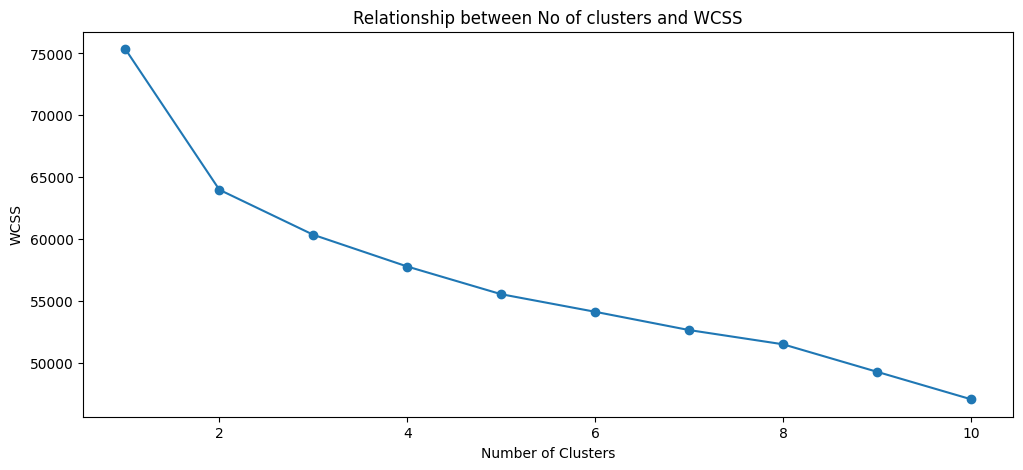

In [69]:
# Visualize the relationship between the number of clusters and WCSS
plt.figure(figsize=(12,5))
plt.plot(K_clusters, wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Relationship between No of clusters and WCSS')
plt.show()


### a.) K Means Clustering

In [77]:
optimal_clusters_k= 3

# Fit the model 
kmeans_ml = KMeans(n_clusters=optimal_clusters_k, init='k-means++', random_state=42,n_init='auto', max_iter=500)
customer['Kmeans'] = kmeans_ml.fit_predict(customer_scaled)

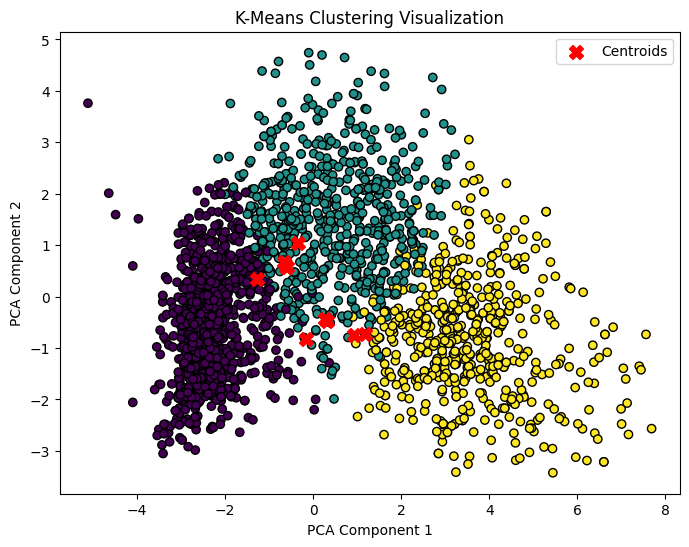

In [78]:
# Visualize the clusters (assuming first two principal components)
plt.figure(figsize=(8,6))
plt.scatter(customer_pca[:, 0], customer_pca[:, 1], c=customer['Kmeans'], cmap='viridis', edgecolors='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red', marker='X', label='Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering Visualization')
plt.legend()
plt.show()

In [72]:
silhouette_avg = silhouette_score(customer_scaled, customer['Kmeans'])
davies_bouldin = davies_bouldin_score(customer_scaled, customer['Kmeans'])
calinski_harabasz = calinski_harabasz_score(customer_scaled, customer['Kmeans'])

print(f'Silhouette Score: {silhouette_avg:.3f}')
print(f'Davies-Bouldin Index: {davies_bouldin:.3f}')
print(f'Calinski-Harabasz Score: {calinski_harabasz:.3f}')

Silhouette Score: 0.115
Davies-Bouldin Index: 2.647
Calinski-Harabasz Score: 274.860


### b.) Hierarchical clustering

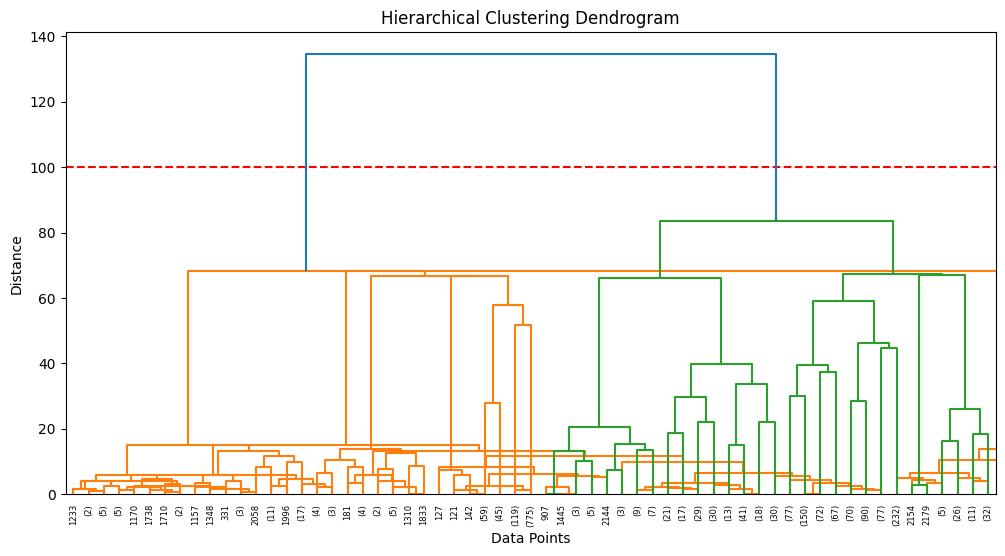

In [73]:
# Perform hierarchical clustering and compute the linkage matrix
linkage_matrix = sch.linkage(customer_scaled, method='ward')  # 'ward' minimizes variance

# Plot the dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.axhline(y=100, color='r', linestyle='--')  # Adjust '500' based on observation
sch.dendrogram(linkage_matrix, truncate_mode='level', p=5)

plt.show()

In [74]:
from scipy.cluster.hierarchy import fcluster

optimal_clusters = fcluster(linkage_matrix, t=100, criterion='distance')  # Adjust 't' based on dendrogram
print(f"Optimal Clusters: {len(set(optimal_clusters))}")

Optimal Clusters: 2


In [ ]:
# Hierarchical Clustering (Agglomerative, with 2 clusters)
hierarchical = AgglomerativeClustering(n_clusters=2, linkage='ward')
customer['hierarchical'] = hierarchical.fit(customer_scaled)

labels = hierarchical.labels_

C:\Users\Esther\AppData\Local\Temp\ipykernel_6644\4215153206.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(customer_pca[:, 0], customer_pca[:, 1], labels, cmap='viridis', edgecolors='k')


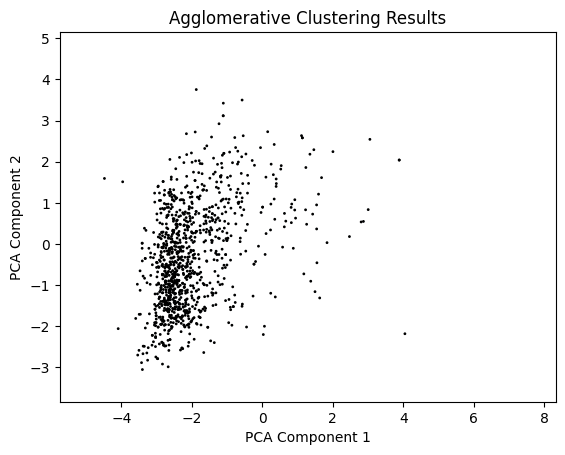

In [75]:
# Agglomerative scatter plots
plt.scatter(customer_pca[:, 0], customer_pca[:, 1], labels, cmap='viridis', edgecolors='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Agglomerative Clustering Results")
plt.show()


In [76]:
# Evaluation of the model
silhouette_avg = silhouette_score(customer_scaled, hierarchical.labels_)
davies_bouldin = davies_bouldin_score(customer_scaled, hierarchical.labels_)
calinski_harabasz = calinski_harabasz_score(customer_scaled, hierarchical.labels_)

print(f'Silhouette Score: {silhouette_avg:.3f}')
print(f'Davies-Bouldin Index: {davies_bouldin:.3f}')
print(f'Calinski-Harabasz Score: {calinski_harabasz:.3f}')

Silhouette Score: 0.130
Davies-Bouldin Index: 2.476
Calinski-Harabasz Score: 302.407


### c.) Gaussian Mixture Models

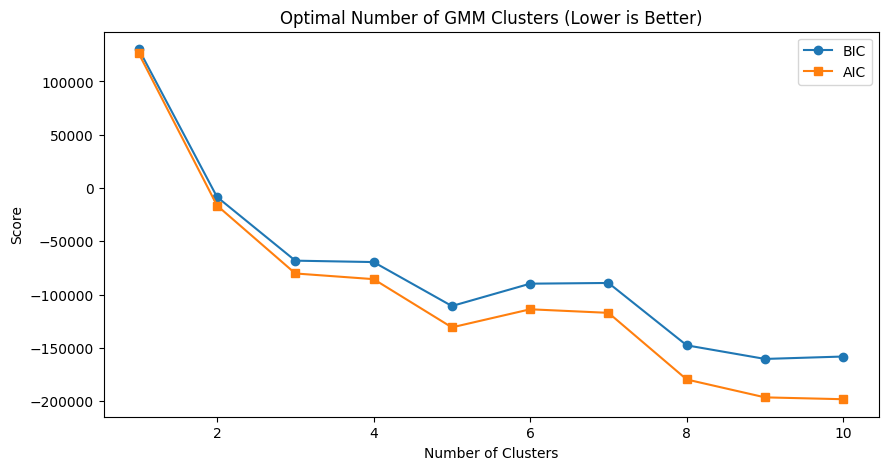

In [79]:
# Determining the optimal number of clusters 
bic_scores = []
aic_scores = []
n_clusters = range(1, 11)

for n in n_clusters:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(customer_scaled)
    bic_scores.append(gmm.bic(customer_scaled))
    aic_scores.append(gmm.aic(customer_scaled))

plt.figure(figsize=(10, 5))
plt.plot(n_clusters, bic_scores, label="BIC", marker="o")
plt.plot(n_clusters, aic_scores, label="AIC", marker="s")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.title("Optimal Number of GMM Clusters (Lower is Better)")
plt.show()


In [80]:
#Gaussian Mixture Model (with 3 components)
gmm = GaussianMixture(n_components=6, random_state=42)
gmm_labels = gmm.fit_predict(customer_scaled)
customer['GMM'] = gmm_labels

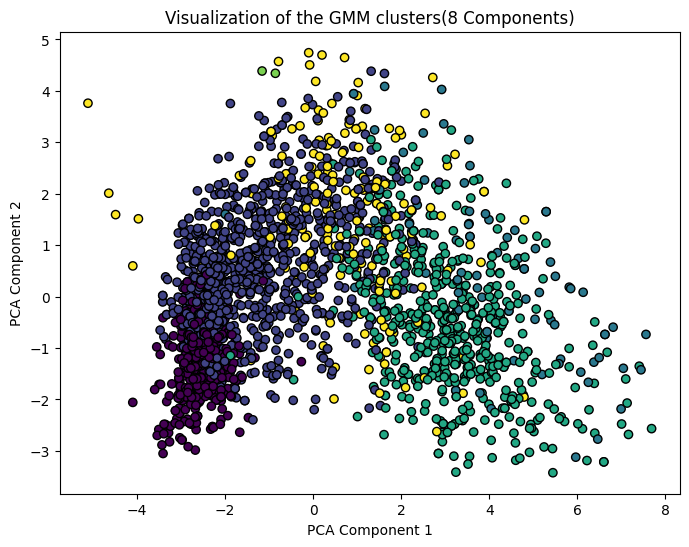

In [81]:
# Visualization of GMM clusters
plt.figure(figsize=(8, 6))
plt.scatter(customer_pca[:, 0], customer_pca[:, 1], c=gmm_labels, cmap='viridis', edgecolors='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Visualization of the GMM clusters(8 Components)")
plt.show()

In [82]:
# Clustering Evaluation Metrics
silhouette_avg = silhouette_score(customer_scaled, gmm_labels)
davies_bouldin = davies_bouldin_score(customer_scaled, gmm_labels)
calinski_harabasz = calinski_harabasz_score(customer_scaled, gmm_labels)

print(f'Silhouette Score: {silhouette_avg:.3f}')
print(f'Davies-Bouldin Index: {davies_bouldin:.3f}')
print(f'Calinski-Harabasz Score: {calinski_harabasz:.3f}')

Silhouette Score: 0.058
Davies-Bouldin Index: 2.636
Calinski-Harabasz Score: 141.633


### d.) DBSCAN

Number of noise points detected: 46


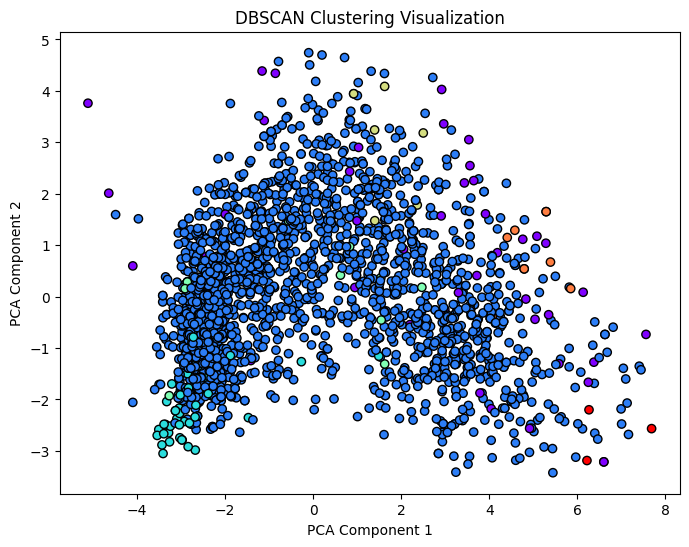

In [83]:
# Performing DBSCAN 
dbscan = DBSCAN(min_samples=5, eps=6.0)
dbscan_labels = dbscan.fit_predict(customer_scaled)
customer['DBSCAN'] = dbscan_labels

# Counting noise points
noise_points = np.sum(dbscan_labels == -1)
print(f"Number of noise points detected: {noise_points}")

# Visualizing DBSCAN Clustering using PCA
plt.figure(figsize=(8, 6))
plt.scatter(customer_pca[:, 0], customer_pca[:, 1], c=dbscan_labels, cmap="rainbow", edgecolors='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering Visualization")
plt.show()



In [84]:
np.unique(dbscan_labels)

array([-1,  0,  1,  2,  3,  4,  5])

In [85]:
silhouette_avg = silhouette_score(customer_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
davies_bouldin = davies_bouldin_score(customer_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
calinski_harabasz = calinski_harabasz_score(customer_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

print(f'Silhouette Score: {silhouette_avg:.3f}')
print(f'Davies-Bouldin Index: {davies_bouldin:.3f}')
print(f'Calinski-Harabasz Score: {calinski_harabasz:.3f}')

Silhouette Score: 0.198
Davies-Bouldin Index: 2.334
Calinski-Harabasz Score: 43.295
